<a href="https://colab.research.google.com/github/Nikita-Gupta-19/Google-Playstore-Apps-rating-Prediction/blob/main/Google_Playstore_Apps_rating_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# **Loading the Dataset**

In [ ]:
df = pd.read_csv('/content/googleplaystore.csv')
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# **Data Preprocessing & Cleaning**

In [ ]:
# 1. Remove exact duplicates
df.drop_duplicates(inplace=True)

# 2. Replace invalid 'Category' entry like '1.9' with NaN
df['Category'] = df['Category'].replace('1.9', np.nan)

# 3. Clean 'Size' column
df['Size'] = df['Size'].astype(str)
df['Size'] = df['Size'].replace('Varies with device', np.nan)
df['Size'] = df['Size'].str.replace('M', '000', regex=False)
df['Size'] = df['Size'].str.replace('k', '', regex=False)
df['Size'] = df['Size'].str.replace(',', '', regex=False)
df['Size'] = df['Size'].str.strip()
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

# 4. Clean 'Installs' column
df['Installs'] = df['Installs'].astype(str)
df['Installs'] = df['Installs'].str.replace(',', '', regex=False)
df['Installs'] = df['Installs'].str.replace('+', '', regex=False)
df['Installs'] = df['Installs'].replace('Free', np.nan)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# 5. Clean 'Reviews' column
df['Reviews'] = df['Reviews'].astype(str)
df['Reviews'] = df['Reviews'].replace('3.0M', '3000000')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# 6. Clean 'Price' column
df['Price'] = df['Price'].astype(str)
df['Price'] = df['Price'].str.replace('$', '', regex=False)
df['Price'] = df['Price'].replace('Everyone', np.nan)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 7. Convert 'Last Updated' to datetime
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

# 8. Drop rows with missing values in critical columns
df.dropna(subset=['Rating', 'Reviews', 'Size', 'Installs',
                  'Price', 'Category', 'Last Updated'], inplace=True)

print("✅ Cleaned data shape:", df.shape)

✅ Cleaned data shape: (7424, 13)


# Feature **Engineering**

In [ ]:
from datetime import datetime

# 1. App Age (in days since last update)
df['App_Age'] = (datetime.now() - df['Last Updated']).dt.days

# 2. Is Expensive (1 if price > median of paid apps)
median_price = df[df['Price'] > 0]['Price'].median()
df['Is_Expensive'] = df['Price'].apply(lambda x: 1 if x > median_price else 0)

# Check new features
df[['App_Age', 'Is_Expensive']].describe()

,App_Age,Is_Expensive
count,7424.000000,7424.000000
mean,2819.278556,0.031250
std,419.638870,0.174004
min,2530.000000,0.000000
25%,2552.000000,0.000000
50%,2621.000000,0.000000
75%,2917.000000,0.000000
max,5531.000000,1.000000


# **Rating Distribution (Basic)**

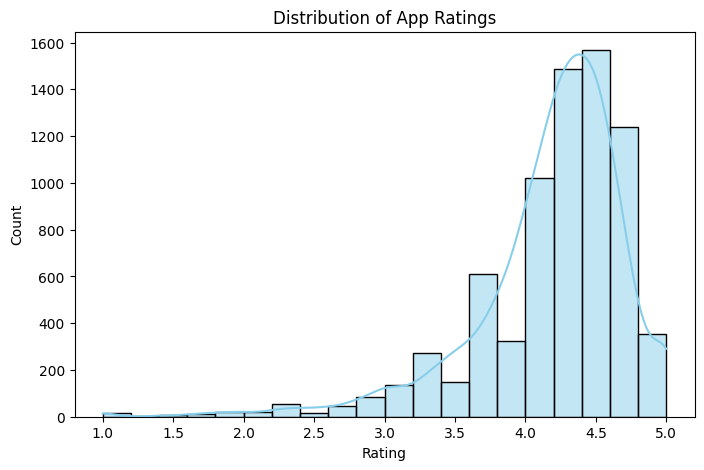

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of App Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# **Boxplot – Price vs Rating (Paid Apps Only)**

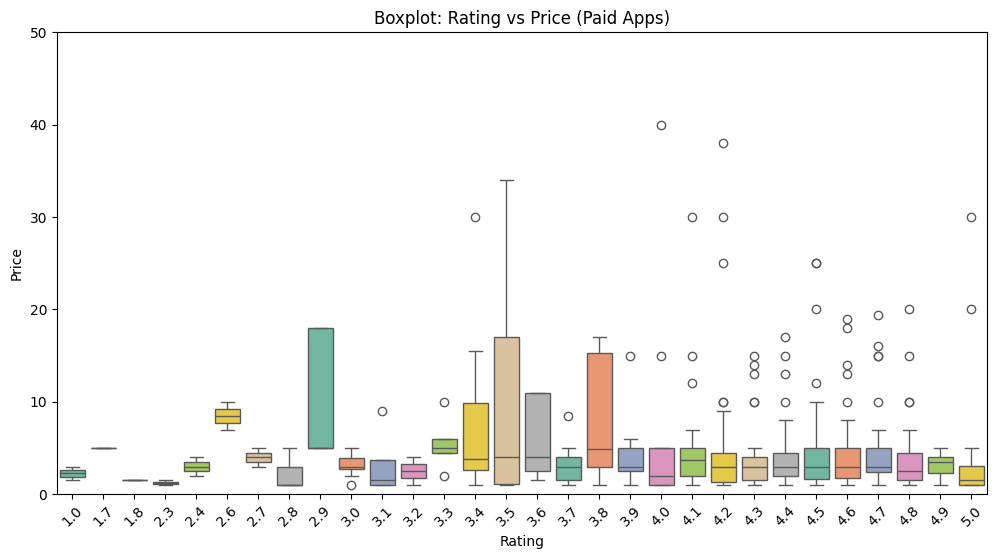

In [ ]:
plt.figure(figsize=(12,6))
paid_apps = df[df['Type'] == 'Paid']
sns.boxplot(x='Rating', y='Price', data=paid_apps, palette='Set2')
plt.ylim(0, 50)
plt.title('Boxplot: Rating vs Price (Paid Apps)')
plt.xticks(rotation=45)
plt.show()

# **Heatmap of Correlations (Numeric Features)**

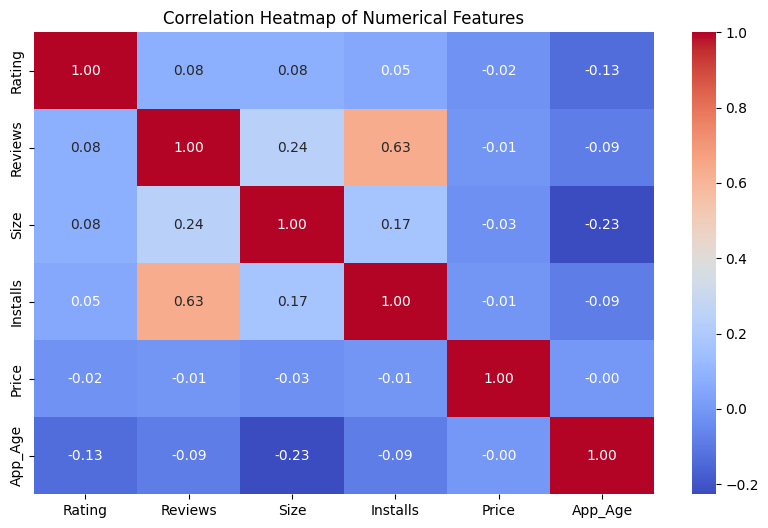

In [ ]:
plt.figure(figsize=(10,6))
numeric_cols = ['Rating', 'Reviews', 'Size', 'Installs', 'Price', 'App_Age']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# **Treemap of Genre Distribution**

In [ ]:
import plotly.express as px
genre_counts = df['Genres'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']
fig = px.treemap(genre_counts,
                 path=['Genre'],
                 values='Count',
                 color='Count',
                 color_continuous_scale='Plasma',
                 title='Genre-wise App Distribution',
                 hover_data={'Count': True})
fig.show()


# **Model Training + Comparison (Random Forest, Linear, Gradient Boosting)**

**Encode Categorical Variables & Prepare Features**

In [ ]:
# Label Encoding for categorical columns
le = LabelEncoder()
df['Category'] = le.fit_transform(df['Category'])
df['Genres'] = le.fit_transform(df['Genres'])
df['Content Rating'] = le.fit_transform(df['Content Rating'])
df['Type'] = le.fit_transform(df['Type'])  # Free=0, Paid=1

# Define X and y
features = ['Category', 'Reviews', 'Size', 'Installs', 'Price',
            'Content Rating', 'Genres', 'App_Age', 'Is_Expensive', 'Type']
X = df[features]
y = df['Rating']

# Fill any remaining NaN values just in case
X.fillna(X.median(), inplace=True)
y.fillna(y.median(), inplace=True)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Train All 3 Models**

In [ ]:
# Initialize models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate each
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}

**Display Results as a Comparison Table**

In [ ]:
# Convert results to DataFrame
result_df = pd.DataFrame(results).T
result_df = result_df.sort_values('R²', ascending=False)
print("🔍 Model Comparison:\n")
display(result_df.style.background_gradient(cmap='YlGnBu'))

🔍 Model Comparison:



,MSE,R²
Gradient Boosting,0.276372,0.134219
Random Forest,0.277338,0.131192
Linear Regression,0.309418,0.030698


# **Feature Importance Plot (Random Forest)**

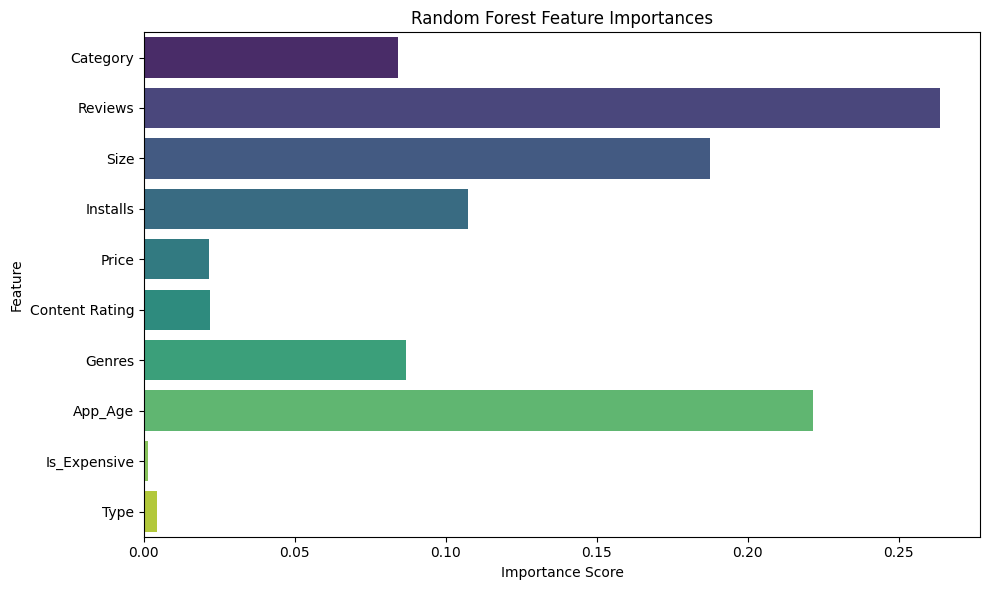

In [ ]:
# Feature importance from Random Forest
rf_model = models['Random Forest']
importances = rf_model.feature_importances_
feature_names = X.columns

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# **SHAP Explainability**

**Install & Import SHAP**

In [ ]:
!pip install shap
import shap
import matplotlib.pyplot as plt

# Sample a small subset of X_test to speed up SHAP
X_sample = X_test.sample(100, random_state=42)

# Create SHAP explainer and compute SHAP values
explainer = shap.TreeExplainer(rf_model)  # rf_model should be your trained RandomForestRegressor
shap_values = explainer.shap_values(X_sample)

**SHAP Summary Plot**

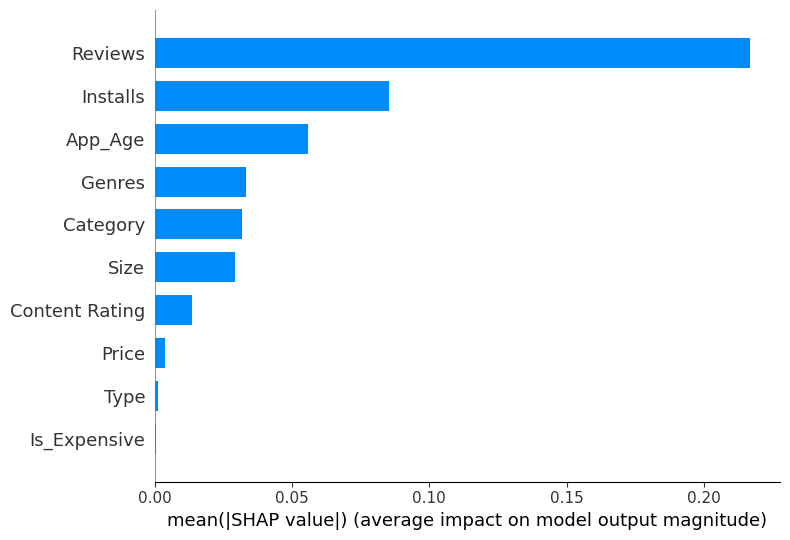

In [ ]:
# Summary plot (overall impact)
shap.summary_plot(shap_values, X_test, plot_type='bar')

**SHAP Force Plot for a Single Prediction**

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[5], X_sample.iloc[5])

# **Cleaned and Engineered dataset**

In [ ]:
# Save the final
df.to_csv("cleaned_playstore_data.csv", index=False)

# Download to your system
from google.colab import files
files.download("cleaned_playstore_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>